# Exploratory analyses

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
import psycopg2
import sql_utils
import os
import sys
import io
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Pull data from postgreSQL db

In [2]:
# select and join the BART and weather data from postgres
bart_weather_df = sql_utils.pg2pd_join(table1='bart_entry_exit', table2='weather',
                           on1='bart_entry_exit.date', on2='weather.datestamp')

In [3]:
bart_weather_df.head()

,id,date,hour,direction,station,entries,exits,day,month,id,datestamp,mean_temperature,max_temperature,min_temperature,precipitation,rain
0,0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
1,1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
2,2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
3,3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
4,4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1


In [4]:
bart_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126069 entries, 0 to 2126068
Data columns (total 16 columns):
id                  int64
date                object
hour                object
direction           object
station             object
entries             int64
exits               int64
day                 object
month               object
id                  int64
datestamp           object
mean_temperature    float64
max_temperature     float64
min_temperature     float64
precipitation       float64
rain                int64
dtypes: float64(4), int64(5), object(7)
memory usage: 259.5+ MB


In [5]:
bart_weather_df['entries'].describe()

count    2.126069e+06
mean     1.710445e+02
std      3.090924e+02
min      1.000000e+00
25%      1.600000e+01
50%      6.100000e+01
75%      1.940000e+02
max      4.412000e+03
Name: entries, dtype: float64

## Check out the distribution

In [58]:
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

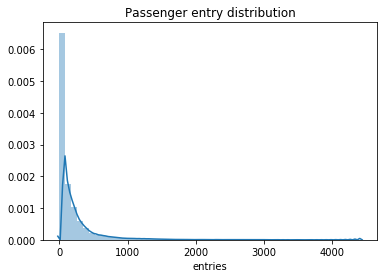

In [75]:
hist = sns.distplot(bart_weather_df['entries'])
plt.title('Passenger entry distribution')
plt.savefig(figpath + 'entries_dist_all.png', 
    dpi=300)

### Identify outliers

In [15]:
# function for identifying outliers using the Z-score method
def outliers_z_score(ys):
    threshold = 3 #setting the outlier criterion as 3 SDs

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

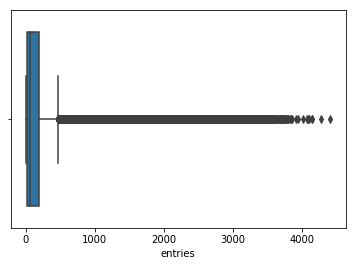

In [16]:
sns.boxplot(bart_weather_df['entries'])

The above plot looks like we have a ton of outliers. However, this likely reflects the sknewedness of entry data. Look below and we see that the very large (i.e. > 3 SDs) entry values correspond to what one might expect to be busy times/stations.

In [17]:
outlier_idx = outliers_z_score(bart_weather_df['entries'])
outlier_data = bart_weather_df.iloc[outlier_idx]

In [27]:
outlier_data

,id,date,hour,direction,station,entries,exits,day,month,id,datestamp,mean_temperature,max_temperature,min_temperature,precipitation,rain
51,51,2011-01-01,1,northbound,MONT,1805,78,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
65,65,2011-01-01,1,southbound,EMBR,1156,54,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
1803,1803,2011-01-03,7,northbound,BALB,1150,45,Monday,1,2,2011-01-03,44.0,51.0,36.0,0.00,0
1849,1849,2011-01-03,8,northbound,24TH,1308,151,Monday,1,2,2011-01-03,44.0,51.0,36.0,0.00,0
1854,1854,2011-01-03,8,northbound,DALY,1140,20,Monday,1,2,2011-01-03,44.0,51.0,36.0,0.00,0
1856,1856,2011-01-03,8,northbound,GLEN,1158,35,Monday,1,2,2011-01-03,44.0,51.0,36.0,0.00,0
1886,1886,2011-01-03,8,southbound,PHIL,1423,16,Monday,1,2,2011-01-03,44.0,51.0,36.0,0.00,0
2265,2265,2011-01-03,16,southbound,POWL,1115,334,Monday,1,2,2011-01-03,44.0,51.0,36.0,0.00,0
2281,2281,2011-01-03,17,northbound,EMBR,1866,221,Monday,1,2,2011-01-03,44.0,51.0,36.0,0.00,0
2285,2285,2011-01-03,17,northbound,MONT,2402,200,Monday,1,2,2011-01-03,44.0,51.0,36.0,0.00,0


In [54]:
# restrict plotting to the following sample of stations
stations_to_plt = ['NCON', 'LAFY', '19TH', 'MONT', '16TH', 'SSAN']
plot_df = bart_weather_df.loc[bart_weather_df['station'].isin(stations_to_plt), :]
# separate s-bound & n-bound directions
plot_nb_df = plot_df.loc[plot_df['direction']=='northbound']
plot_nb_df.drop(labels=['id'], axis=1, inplace=True)
plot_sb_df = plot_df.loc[plot_df['direction']=='southbound']
plot_sb_df.drop(labels=['id'], axis=1, inplace=True)

In [55]:
plot_nb_df.head()

,date,hour,direction,station,entries,exits,day,month,datestamp,mean_temperature,max_temperature,min_temperature,precipitation,rain
1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,2011-01-01,43.0,45.0,40.0,0.36,1
2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,2011-01-01,43.0,45.0,40.0,0.36,1
11,2011-01-01,0,northbound,LAFY,3,21,Saturday,1,2011-01-01,43.0,45.0,40.0,0.36,1
13,2011-01-01,0,northbound,MONT,343,114,Saturday,1,2011-01-01,43.0,45.0,40.0,0.36,1
18,2011-01-01,0,northbound,SSAN,8,1,Saturday,1,2011-01-01,43.0,45.0,40.0,0.36,1


In [ ]:
by_hour = data.groupby(data.index.dayofweek).mean()

In [ ]:
# plot average entries x hour colored by station, separate for n-bound & s-bound. Maybe only restricted to Weekdays
# Just load seaborn and the chart looks better:
sns.
plt.plot( 'hour', 'station', data=df, marker='o', color='mediumvioletred')
plt.show()


In [39]:
#rowdicts = [] 
#for l, d in bart_entry_df.groupby("hour station direction".split()):
#    d = {"hour": l[0], "station": l[1], "direction": l[2]}
#    rowdicts.append(d)                               
#
#df2 = pd.DataFrame.from_dict(rowdicts)
nb_grouped_df = plot_sb_df.groupby(['hour', 'station']).mean()
nb_grouped_df.reset_index(inplace=True)
nb_grouped_df.drop(labels=['id','month'], axis=1, inplace=True)

In [40]:
nb_grouped_df.head()

,hour,station,entries,exits,mean_temperature,max_temperature,min_temperature,precipitation,rain
0,0,16TH,51.623207,83.853542,61.474576,73.282051,49.186875,0.042951,0.154281
1,0,19TH,56.859617,4.144941,61.572015,73.432088,49.233820,0.041449,0.150410
2,0,LAFY,3.692650,1.744989,62.063474,74.085746,49.582405,0.032673,0.138085
3,0,MONT,115.654031,12.690196,61.475381,73.287146,49.183007,0.042980,0.153377
4,0,NCON,2.532319,1.201521,61.083650,72.984791,48.673004,0.048517,0.159696


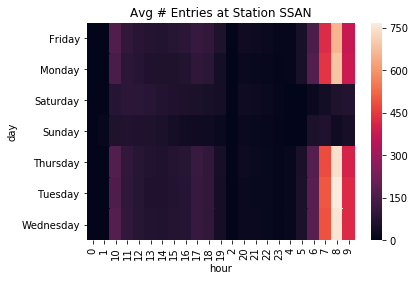

In [73]:
for stn in stations_to_plt:
    # filter for the Mcarthur station
    stn_df = plot_nb_df.loc[plot_nb_df['station']==stn, :]

    # avg by station by hour, day, month
    #mean_df = stn_df.groupby(by=['station', 'day', 'hour']).mean()['entries']
    #mean_df.fillna(value=0, inplace=True)
    
    day_hour_avg = stn_df.groupby(by=['day', 'hour']).mean()['entries'].unstack()
    day_hour_avg.fillna(value=0, inplace=True)
    
    # plot heat map of the days and hours with most rides
    plt.clf()
    sns.heatmap(day_hour_avg)
    plt.title('Avg # Entries at Station ' + stn)
    plt.savefig(figpath + 'station_heatmap_' + stn + '_nbound.png')

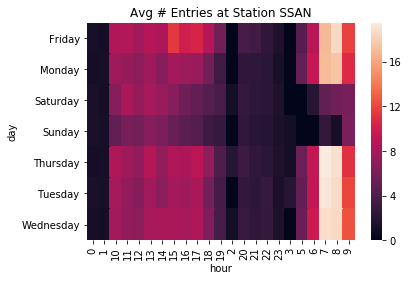

In [74]:
for stn in stations_to_plt:
    # filter for the Mcarthur station
    stn_df = plot_sb_df.loc[plot_sb_df['station']==stn, :]

    # avg by station by hour, day, month
    #mean_df = stn_df.groupby(by=['station', 'day', 'hour']).mean()['entries']
    #mean_df.fillna(value=0, inplace=True)
    
    day_hour_avg = stn_df.groupby(by=['day', 'hour']).mean()['entries'].unstack()
    day_hour_avg.fillna(value=0, inplace=True)
    
    # plot heat map of the days and hours with most rides
    plt.clf()
    sns.heatmap(day_hour_avg)
    plt.title('Avg # Entries at Station ' + stn)
    plt.savefig(figpath + 'station_heatmap_' + stn + '_sbound.png')

In [66]:
stn_df = plot_sb_df.loc[plot_sb_df['station']==stn, :]

In [68]:
day_hour_avg = stn_df.groupby(by=['day', 'hour']).mean()['entries'].unstack()

In [69]:
day_hour_avg.head()

hour,0,1,10,11,12,13,14,15,16,17,...,20,21,22,23,3,5,6,7,8,9
day,,,,,,,,,,,,,,,,,,,,,
Friday,1.228571,1.117647,8.532110,8.581538,7.808642,8.737003,8.383436,11.378049,10.048780,10.425076,...,3.711475,3.384354,2.455224,1.618785,NaN,4.381250,8.873457,17.006154,18.561728,11.764526
Monday,1.142857,1.166667,7.763804,7.289634,6.790123,7.638037,6.619632,7.963415,7.565749,7.530864,...,2.458647,2.365854,2.182156,1.265625,NaN,5.081633,9.476667,17.047771,17.503165,10.734756
Saturday,1.353982,1.138889,6.564815,8.208589,7.312883,8.040000,7.418462,6.608696,5.567901,4.952532,...,2.702206,2.318182,2.216216,1.586207,NaN,NaN,2.000000,4.907051,5.698758,5.934985
Sunday,1.372340,1.264706,4.937500,5.945122,5.796923,6.669753,6.082822,5.249231,4.616352,4.204473,...,2.538462,2.097872,1.928000,1.380952,1.0,NaN,NaN,2.666667,1.214286,6.027864
Thursday,1.093333,1.166667,8.398176,7.585366,7.106707,8.753049,7.206687,8.461774,8.341538,8.972644,...,3.185185,2.563177,2.169811,1.535714,1.0,5.402516,9.375000,19.526480,18.978193,11.069909


Do some pivots to get a glimpse of temporal trends

In [150]:
day_hour_avg = df_mcar.groupby(by=['day', 'hour']).mean()['entries'].unstack()
day_hour_avg.fillna(value=0, inplace=True)
day_hour_avg.head(10)

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Friday,14.480000,2.50,0.0,0.0,10.291667,29.232323,88.019231,254.759615,389.990385,304.333333,...,105.931373,115.862745,154.647059,224.656863,191.372549,134.784314,81.686275,63.911765,54.382353,41.372549
Monday,11.434343,2.00,0.0,0.0,12.000000,29.923077,88.505155,269.122449,397.009615,293.951923,...,90.721154,96.990385,133.644231,202.009615,175.423077,92.615385,52.509615,41.990385,35.153846,22.990385
Saturday,27.019608,20.75,35.0,17.5,0.000000,0.000000,15.750000,38.272727,59.480392,87.803922,...,119.500000,102.539216,98.803922,102.480392,90.441176,91.480392,73.029412,59.980392,53.519608,40.480392
Sunday,26.147059,1.00,0.0,0.0,0.000000,0.000000,220.000000,149.500000,33.098039,58.186275,...,95.147059,78.823529,67.343137,65.392157,61.578431,51.823529,42.480392,39.225490,32.960784,22.921569
Thursday,13.845361,0.00,0.0,0.0,13.240000,32.039216,99.960784,295.029412,439.615385,333.730769,...,99.028846,105.740385,146.086538,238.432692,206.173077,113.250000,66.865385,53.336538,46.471154,28.480769
Tuesday,11.294737,0.00,0.0,0.0,12.666667,31.165049,99.625000,299.576923,455.355769,337.067308,...,92.942308,100.826923,146.894231,230.528846,204.567308,105.894231,58.278846,49.980769,41.673077,25.711538
Wednesday,13.473684,4.00,0.0,0.0,12.387755,31.990291,98.250000,294.807692,470.211538,334.346154,...,97.423077,104.884615,148.586538,235.125000,203.326923,109.384615,60.451923,51.538462,43.576923,27.961538


Text(0.5,1,'Avg # entries at MacArthur station')

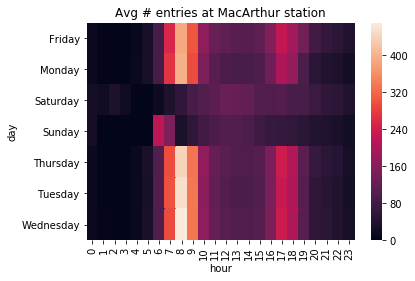

In [151]:
# plot heat map of the days and hours with most rides
sns.heatmap(day_hour_avg)
plt.title('Avg # entries at MacArthur station')

Might want to investigate the 6am blip on Sunday. Seems like a weird time to have a ridership spike.